In [1]:
!pip install pandas
!pip install opencv-python
!pip install tensorflow-cpu
!pip install matplotlib

  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.7.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth-2.22.0-py2.py3-none-any.whl (181 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Attempti

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.22.0 which is incompatible.
google-cloud-core 1.7.1 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.22.0 which is incompatible.
google-api-core 1.25.1 requires google-auth<2.0dev,>=1.21.1, but you have google-auth 2.22.0 which is incompatible.


In [2]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 


import scipy


C:\Users\sathw\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')


Num GPUs Available:  0


In [4]:
#define image dataset 
#why do we rescale?
WIDTH,HEIGHT=176,208
image_generator = ImageDataGenerator(rescale=1/255,validation_split=0,shear_range =.25, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(WIDTH,HEIGHT), 
                                                 subset="training",
                                                 class_mode='categorical')


image_generator_submission = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_dataset = image_generator_submission.flow_from_directory(batch_size=8,
                                                 directory='Alzheimer_s Dataset/test',
                                                 shuffle=True,
                                                 target_size=(WIDTH,HEIGHT), 
                                                 class_mode='categorical')


submission = image_generator_submission.flow_from_directory(
                                                 directory='Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(WIDTH,HEIGHT), 
                                                 subset="validation",
                                                 class_mode=None)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


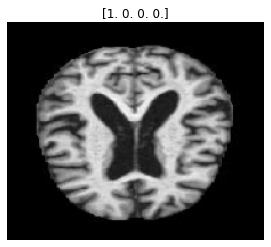

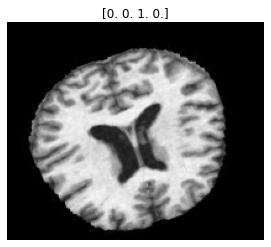

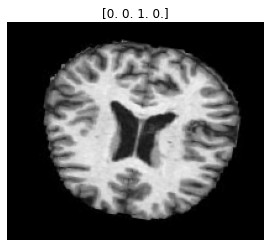

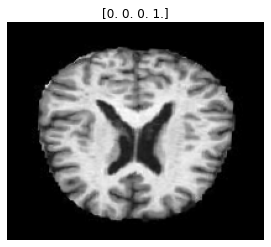

In [5]:
#show flwoers for the first batch

batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

## CNN

In [6]:
#experiment with Convolutional neural net
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [WIDTH,HEIGHT,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [7]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [9]:
model.compile(
        optimizer='adam',
        loss=tensorflow.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [10]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [15]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=40
)

Epoch 1/40
641/641 [==============================] - 170s 260ms/step - loss: 1.0810 - accuracy: 0.7680 - precision: 0.5630 - recall: 0.3212 - auc: 0.7837 - f1_score: 0.4052 - val_loss: 1.1224 - val_accuracy: 0.7228 - val_precision: 0.3840 - val_recall: 0.1798 - val_auc: 0.7400 - val_f1_score: 0.2401 - lr: 0.0100
Epoch 2/40
641/641 [==============================] - 153s 239ms/step - loss: 0.9978 - accuracy: 0.7778 - precision: 0.6399 - recall: 0.2541 - auc: 0.8010 - f1_score: 0.3593 - val_loss: 172.1414 - val_accuracy: 0.7502 - val_precision: 0.5004 - val_recall: 0.5004 - val_auc: 0.6669 - val_f1_score: 0.5003 - lr: 0.0089
Epoch 3/40
641/641 [==============================] - 123s 192ms/step - loss: 0.9899 - accuracy: 0.7806 - precision: 0.6697 - recall: 0.2412 - auc: 0.8047 - f1_score: 0.3501 - val_loss: 1.0503 - val_accuracy: 0.7746 - val_precision: 0.5763 - val_recall: 0.3722 - val_auc: 0.8153 - val_f1_score: 0.4430 - lr: 0.0079
Epoch 4/40
641/641 [==============================] -

In [13]:
model.evaluate(validation_dataset)

160/160 [==============================] - 7s 41ms/step - loss: 1.3863 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - f1_score: 0.0000e+00


[1.386292576789856, 0.75, 0.0, 0.0, 0.5, 0.0]

In [14]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

NameError: name 'history' is not defined

In [35]:
scores = model.evaluate_generator(validation_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7961297631263733
Precision =  0.8189189434051514
Recall =  0.2369038313627243
AUC =  0.8379567861557007
F1_score =  0.35145509243011475


In [37]:
import tensorflow as tf

# Assuming you have trained and fitted your model, `model`, already

# Save the model in SavedModel format
tf.saved_model.save(model, 'model.h5')

In [38]:
model.save('snapshot.h5')